In [1]:
!pip install tld

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from tld import get_tld

nltk.download('stopwords')
from nltk.corpus import stopwords

en_stopwords = set(stopwords.words("english"))
en_stopwords.update([s.capitalize() for s in stopwords.words("english")])

import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from google.colab import drive

import bz2
import json
from datetime import datetime

nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path_to_file = '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2' 

In [5]:

max_num_citation = 10000

df_news = pd.DataFrame({'quoteID': [],
                   'quotation': [],
                   'urls': [],
                   'speaker': []                   
                   })

with bz2.open(path_to_file, 'rb') as s_file:
    for i, instance in zip(range(max_num_citation), s_file):
        instance = json.loads(instance) # loading a sample

#instance['qids'], instance['speaker']

    df_news.loc[len(df_news.index)] = [instance['quoteID'], instance['quotation'], instance['urls'], instance['speaker']]
    if i % 1000 == 0:
      print(f'Iteration: {i}')

df_news

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Iteration: 0
Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000


,quoteID,quotation,urls,speaker
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,[http://israelnationalnews.com/News/News.aspx/...,None
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,[http://thehill.com/opinion/international/4782...,Sue Myrick
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,[https://indianexpress.com/article/business/ec...,None
3,2020-02-15-000053,"... [ I ] f it gets to the floor,",[https://patriotpost.us/opinion/68622-trump-bu...,None
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,[https://people.com/parents/meghan-king-edmond...,Meghan King Edmonds
...,...,...,...,...
9995,2020-03-02-078576,"Why now, 2021? Here's why,",[https://thecourier.com/ohio-news/2020/03/02/p...,Michael J. Graham
9996,2020-04-14-074488,Why should a running back be treated less than...,[http://registercitizen.com/sports/article/Ing...,Mark Ingram
9997,2020-04-15-078413,"Why would I leave here where I'm healthy, to t...",[https://www.bbc.co.uk/news/uk-england-london-...,Pauline Pearce
9998,2020-01-18-055386,"Will he be back? And if so, will it be with th...",[http://www.mywebtimes.com/2020/01/14/full-cou...,None


In [6]:
df_news = df_news.explode("urls")

In [7]:
from urllib.parse import urlparse

def parse_url(url):
  parse_object = urlparse(url)
  return parse_object.netloc

def extract_domain(url):
    url_pruned = urlparse(url).netloc
    tld = get_tld(url, as_object=True).tld
    url_no_tld = url_pruned.replace('.'+tld,"")
    domain = url_no_tld.split('.')[-1]

    return domain

In [8]:
def preprocess(sentence, words_to_exclude = set()):
    #sentence = sentence.lower()
    
    sentence = re.sub(r'(?<![A-Z\W])(?=[A-Z])', ' ',  sentence)
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    word_tokens = tokenizer.tokenize(sentence)
        
    #ps = PorterStemmer()
    #filtered_sentence = [ps.stem(w) for w in word_tokens if not w in stopwords]
   
    # TODO Pos tag before lemmatizing ? https://stackoverflow.com/questions/32957895/wordnetlemmatizer-not-returning-the-right-lemma-unless-pos-is-explicit-python
    lemmatizer = WordNetLemmatizer()
    lem_sentence = [lemmatizer.lemmatize(w) for w in word_tokens]
    
    #filtered_sentence = [''.join([i for i in w if not i.isdigit()]) for w in lem_sentence if not w.isnumeric()]
    filtered_sentence = [w for w in lem_sentence if not w in en_stopwords]

    #bigram = [w1 + " " + w2 for w1,w2 in zip(filtered_sentence[:-1], filtered_sentence[1:])]
    #filtered_sentence += bigram
    #filtered_sentence = [w for w in filtered_sentence if w not in words_to_exclude]
        
    return filtered_sentence

In [9]:
df_news["unique_tokens"] = df_news["quotation"].apply(lambda x: list(set(preprocess(x))))

In [10]:
df_news["newspaper"] = df_news["urls"].apply(extract_domain)

In [16]:
most_common_newspaper = [npaper for npaper, c in Counter(df_news["newspaper"]).most_common()[:20]]

In [17]:
most_common_newspaper

['msn',
 'einnews',
 'breitbart',
 'washingtontimes',
 'businessinsider',
 'indiatimes',
 'nytimes',
 'foxnews',
 'timesofisrael',
 'sfgate',
 'nbcsports',
 'nbcnews',
 'independent',
 'nhregister',
 'ctpost',
 'wsbradio',
 'newstimes',
 'stamfordadvocate',
 'seattletimes',
 'wtmj']

In [18]:
df_news[df_news["newspaper"].isin(most_common_newspaper)]

,quoteID,quotation,urls,speaker,unique_tokens,newspaper
11,2020-04-08-000247,[ W ] henever a defendant is in custody and do...,https://www.washingtontimes.com/news/2020/apr/...,None,"[preliminary, period, court, doe, time, defend...",washingtontimes
18,2020-03-18-000414,20 people are at stranded at Warsaw airport. W...,https://timesofindia.indiatimes.com/india/coro...,None,"[board, airport, u, help, stranded, Flight, al...",indiatimes
21,2020-02-03-000717,"50-YEAR-OLD J-LO, 43-YEAR-OLD SHAKIRA STAR IN ...",http://sfgate.com/entertainment/article/Let-s-...,None,"[LO, SEXUAL, 50, OLD, J, SHAKIRA, STAR, HALF, ...",sfgate
59,2020-01-27-002200,About 16 lakh students of Delhi government sch...,http://timesofindia.indiatimes.com/elections/a...,Arvind Kejriwal,"[hard, correct, government, parent, IIT, stude...",indiatimes
67,2020-04-08-001814,After 10 years of growth we will experience a ...,http://www.breitbart.com/news/france-germany-f...,Peter Altmaier,"[recession, experience, year, growth, 10]",breitbart
...,...,...,...,...,...,...
9980,2020-01-28-111180,While strong customer loyalty should keep sale...,http://www.msn.com/en-us/money/topstocks/analy...,Andy Hargreaves,"[customer, keep, time, Pad, Phone, coming, com...",msn
9987,2020-03-18-093243,who earn a million dollars.,http://breitbart.com/politics/2020/03/18/white...,Steven Mnuchin,"[million, earn, dollar]",breitbart
9988,2020-03-16-082431,who has a bill coming up that they're not sure...,http://mobile.nytimes.com/2020/03/16/business/...,Shea Serrano,"[coming, ha, sure, able, pay, bill, na, gon]",nytimes
9988,2020-03-16-082431,who has a bill coming up that they're not sure...,http://www.nytimes.com/2020/03/16/business/cor...,Shea Serrano,"[coming, ha, sure, able, pay, bill, na, gon]",nytimes


In [19]:
news_doc = df_news[df_news["newspaper"].isin(most_common_newspaper)].groupby("newspaper")["unique_tokens"].apply(sum).apply(lambda l: " ".join(l))

newspapers = news_doc.index

In [20]:
newspapers.shape

(20,)

In [21]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs

In [24]:
# Vectorize document using TF-IDF
tfidf = TfidfVectorizer()

# Fit and Transform the documents
newspaper_term_tfidf= tfidf.fit_transform(news_doc) 

u, s, vt = svds(newspaper_term_tfidf, k= 15)

In [25]:
us = u @ (np.eye(s.shape[0]) * s)
us.shape

(20, 15)

In [26]:
from sklearn.decomposition import PCA

In [27]:
pca = PCA(n_components=2, svd_solver='full')
projected = pca.fit_transform(us)

In [28]:
x = projected[:,0]
y = projected[:,1]

In [29]:
projected.shape

(20, 2)

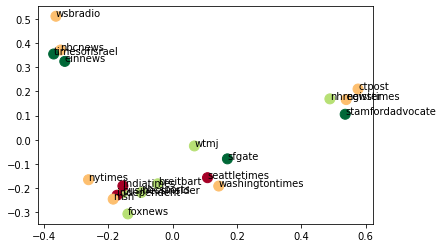

In [31]:
c = np.random.randint(1,5,size=x.shape[0])

norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn

plt.scatter(x,y,c=c, s=100, cmap=cmap, norm=norm)

for i, txt in enumerate(newspapers):
    plt.annotate(txt, (x[i], y[i]))

In [161]:
print(newspaper_term_tfidf.shape)
print(u.shape)
print(s.shape)
print(vt.shape)

(3183, 16298)
(3183, 300)
(300,)
(300, 16298)


In [ ]:
# Vectorize document using TF-IDF
tfidf = TfidfVectorizer()

# Fit and Transform the documents
train_data = tfidf.fit_transform(news_doc) 

In [ ]:
train_data.shape

(3786, 16298)

In [ ]:
num_components=10

# Create SVD object
lsa = TruncatedSVD(n_components=num_components, n_iter=100, random_state=42)

# Fit SVD model on data
lsa.fit_transform(train_data)

# Get Singular values and Components 
Sigma = lsa.singular_values_ 
V_transpose = lsa.components_.T

In [ ]:
V_transpose.shape

(16298, 10)

In [ ]:
terms = tfidf.get_feature_names()

for index, component in enumerate(lsa.components_):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:5]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['wa', 'people', 'want', 'ha', 'get']
Topic 1:  ['explosion', 'equally', 'endanger', 'agreeing', 'nature']
Topic 2:  ['want', 'english', 'competition', 'football', 'liberated']
Topic 3:  ['leniency', 'logically', 'achieved', 'entitled', 'person']
Topic 4:  ['le', 'truth', 'question', 'sleep', 'telling']
Topic 5:  ['necessary', 'accurate', 'scope', 'determination', 'defeat']
Topic 6:  ['hortons', 'tim', 'define', 'doe', 'halted']
Topic 7:  ['conned', 'thole', 'sh', 'govt', 'ha']
Topic 8:  ['leniency', 'logically', 'achieved', 'entitled', 'court']
Topic 9:  ['many', 'people', 'attempted', 'pleading', 'withholding']


In [ ]:
vectorizer = CountVectorizer()
tf = vectorizer.fit_transform(news_doc)
terms_occurence = vectorizer.vocabulary_
terms = vectorizer.get_feature_names()
tf_matrix = tf.toarray().T

[('zeenews.india.com', 1),
 ('yubanet.com', 1),
 ('yourstory.com', 1),
 ('yourmoney.com', 1),
 ('yourlocalguardian.co.uk', 1),
 ('yourhub.denverpost.com', 1),
 ('yourhoustonnews.com', 1),
 ('yorkpress.co.uk', 1),
 ('yellowhammernews.com', 1),
 ('yardbarker.com', 1),
 ('yallpolitics.com', 1),
 ('yalibnan.com', 1),
 ('yaleglobal.yale.edu', 1),
 ('yaledailynews.com', 1),
 ('wyomingpublicmedia.org', 1),
 ('wydaily.com', 1),
 ('wxxinews.org', 1),
 ('wxow.com', 1),
 ('www2.wsls.com', 1),
 ('www2.ljworld.com', 1),
 ('www2.kusports.com', 1),
 ('www1.skysports.com', 1),
 ('www.zdnet.com', 1),
 ('www.zawya.com', 1),
 ('www.yumasun.com', 1),
 ('www.yukon-news.com', 1),
 ('www.youthkiawaaz.com', 1),
 ('www.yourtango.com', 1),
 ('www.yourlocalguardian.co.uk', 1),
 ('www.yourinvestmentpropertymag.com.au', 1),
 ('www.yourhoustonnews.com', 1),
 ('www.yourdailyjournal.com', 1),
 ('www.youngwitness.com.au', 1),
 ('www.yorktonthisweek.com', 1),
 ('www.yorkshirepost.co.uk', 1),
 ('www.yorkshireeveningpost

In [ ]:
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return t.replace(second=0, microsecond=0, minute=0, hour=0)

In [ ]:
path_to_out = '/content/quotes-2020-domains.json.bz2'

max_num_citation = 10000

df = pd.DataFrame({'quoteID': [],
                   'quotation': [],
                   'date': [],
                   #'qids': [],
                   #'speaker': []
                   "numOccurrences":[]
                   })

with bz2.open(path_to_file, 'rb') as s_file:
  for i, instance in zip(range(max_num_citation), s_file):
    instance = json.loads(instance) # loading a sample

#instance['qids'], instance['speaker']

    df.loc[len(df.index)] = [instance['quoteID'], instance['quotation'], instance['date'].split(" ")[0], instance['numOccurrences']]
    if i % 1000 == 0:
      print(f'Iteration: {i}')

df

Iteration: 0
Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000


,quoteID,quotation,date,numOccurrences
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,2020-01-28,1.0
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,2020-01-16,1.0
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,2020-02-10,1.0
3,2020-02-15-000053,"... [ I ] f it gets to the floor,",2020-02-15,2.0
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,2020-01-24,4.0
...,...,...,...,...
9995,2020-03-02-078576,"Why now, 2021? Here's why,",2020-03-02,1.0
9996,2020-04-14-074488,Why should a running back be treated less than...,2020-04-14,1.0
9997,2020-04-15-078413,"Why would I leave here where I'm healthy, to t...",2020-04-15,1.0
9998,2020-01-18-055386,"Will he be back? And if so, will it be with th...",2020-01-18,1.0


TODO 
- Test if removing stopwords before lemmatizing as an influence
- Is keeping maj a good idea ? Could flatten a spike in half of the same term have a maj and not the other depending on the speaker / place of the term in the sentance

---



In [ ]:
df["unique_tokens"] = df["quotation"].apply(lambda x: " ".join(list(set(preprocess(x)))))

In [ ]:
date_term = df.groupby("date")["unique_tokens"].apply(sum)

In [ ]:
date_term

date
2020-01-01    ha planned anything date like Bangladeshrealis...
2020-01-02    one yardlist ha Apparently want everything hea...
2020-01-03    border going wa lot MPP policy right happening...
2020-01-04    back going morning kid work run get ready scho...
2020-01-05    body person station Peshawar matter old wa Sik...
                                    ...                        
2020-04-13    see Harry British go outside category wa carry...
2020-04-14    exactly hopedpandemic ha church virus worldwid...
2020-04-15    Queen coverfast taken hospital starting wa unw...
2020-04-16    perfect want dark always blue burst set light ...
2020-04-17    contact Christ Bringing Evangelicals Amazon co...
Name: unique_tokens, Length: 108, dtype: object

In [ ]:
df["weighted_unique_tokens"] = df[["numOccurrences", "quotation"]].apply(lambda x: [(p, x[0]) for p in set(preprocess(x[1]))] , axis=1)

In [ ]:
date_term_occ = df.groupby("date")["weighted_unique_tokens"].apply(sum)
date_term_occ

date
2020-01-01    [(ha, 1.0), (planned, 1.0), (anything, 1.0), (...
2020-01-02    [(one, 1.0), (yard, 1.0), (list, 2.0), (ha, 2....
2020-01-03    [(border, 1.0), (going, 1.0), (wa, 1.0), (lot,...
2020-01-04    [(back, 2.0), (going, 2.0), (morning, 2.0), (k...
2020-01-05    [(body, 1.0), (person, 1.0), (station, 1.0), (...
                                    ...                        
2020-04-13    [(see, 1.0), (Harry, 1.0), (British, 1.0), (go...
2020-04-14    [(exactly, 1.0), (hoped, 1.0), (pandemic, 1.0)...
2020-04-15    [(Queen, 1.0), (cover, 1.0), (fast, 1.0), (tak...
2020-04-16    [(perfect, 2.0), (want, 2.0), (dark, 2.0), (al...
2020-04-17    [(contact, 2.0), (Christ, 2.0), (Bringing, 2.0...
Name: weighted_unique_tokens, Length: 108, dtype: object

In [ ]:
from itertools import groupby

def merge_tuple(l):

  for key, values in groupby(l, lambda x : x[0]):
      yield key, sum(item[1] for item in subiter) 


In [ ]:
date_term_occ.apply(merge_tuple)
date_term_occ

date
2020-01-01    [(ha, 1.0), (planned, 1.0), (anything, 1.0), (...
2020-01-02    [(one, 1.0), (yard, 1.0), (list, 2.0), (ha, 2....
2020-01-03    [(border, 1.0), (going, 1.0), (wa, 1.0), (lot,...
2020-01-04    [(back, 2.0), (going, 2.0), (morning, 2.0), (k...
2020-01-05    [(body, 1.0), (person, 1.0), (station, 1.0), (...
                                    ...                        
2020-04-13    [(see, 1.0), (Harry, 1.0), (British, 1.0), (go...
2020-04-14    [(exactly, 1.0), (hoped, 1.0), (pandemic, 1.0)...
2020-04-15    [(Queen, 1.0), (cover, 1.0), (fast, 1.0), (tak...
2020-04-16    [(perfect, 2.0), (want, 2.0), (dark, 2.0), (al...
2020-04-17    [(contact, 2.0), (Christ, 2.0), (Bringing, 2.0...
Name: weighted_unique_tokens, Length: 108, dtype: object

TODO make sure that there is an entry for every date of a year

In [ ]:
vectorizer = CountVectorizer()
tf = vectorizer.fit_transform(date_term.values)


In [ ]:
#vectorizer.vocabulary_
term_pos = vectorizer.get_feature_names()
tf_matrix = tf.toarray().T

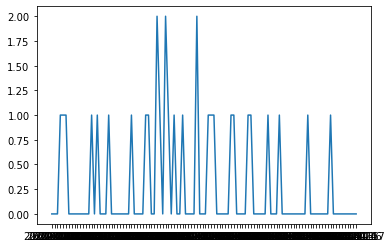

In [ ]:
plt.plot(date_term.index, tf_matrix[term_pos.index("climate")])
plt.show()

In [ ]:
tf_matrix.shape

(24146, 108)

In [ ]:
df[df["quotation"].str.contains(" wa ")].head(10)["quotation"]

194    Babalawo mo wa bebe / oni ma ma t' owo b' enu...
Name: quotation, dtype: object

In [ ]:
df[df["unique_tokens"].apply(lambda l: "wa" in l)]

,quoteID,quotation,date,numOccurrences,unique_tokens
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,2020-01-28,1.0,important non create bringing Prime participat...
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,2020-01-16,1.0,Department Homeland Security wa urged livid ag...
11,2020-04-08-000247,[ W ] henever a defendant is in custody and do...,2020-04-08,1.0,10 period custody personally hearing must defe...
19,2020-02-21-000455,2019 was a landmark year for Fiverr as we comp...,2020-02-21,1.0,increased extraordinary momentum landmark inte...
23,2020-01-05-000384,"A 25-year-old Sikh man, was killed by unidenti...",2020-01-05,1.0,body person station Peshawar matter old wa Sik...
...,...,...,...,...,...
9959,2020-02-21-082227,"When it was brought up last year, I kind of kn...",2020-02-21,5.0,Even passed something going brought wa knew fi...
9965,2020-02-17-085101,When we realised that mealie-meal was too expe...,2020-02-17,1.0,afford meal subsidy unscrupulous could black m...
9978,2020-01-13-093494,While most casual fans are familiar with Tagov...,2020-01-13,9.0,Day catching wide threat NFL drive destroyed t...
9992,2020-03-26-086036,"Why can't we use Heras fencing, get it all clo...",2020-03-26,1.0,enable minute closed issue Piccadilly disperse...


In [ ]:




date_term.apply(lambda s: Counter(vocabulary))

In [ ]:
dict(Counter(date_term.apply(lambda x: x.split()).explode().values).most_common()[::-1])

{'indigenous': 1,
 'Evangelicals': 1,
 'decisionleader': 1,
 'totalinform': 1,
 'Wicklow': 1,
 'economysetting': 1,
 'closely3': 1,
 'alarmed': 1,
 'bagaware': 1,
 'strugglingcurbside': 1,
 'equationreasonably': 1,
 'evercombination': 1,
 'workflow': 1,
 'Video': 1,
 'COTS': 1,
 'Solutions': 1,
 'TAG': 1,
 'Friction': 1,
 'Cloud': 1,
 '19Zer0': 1,
 'ITU': 1,
 'Neighbor188': 1,
 'roadside': 1,
 'panicGood': 1,
 'uncontrollable': 1,
 'Rajokarifear': 1,
 'Mahipalpur': 1,
 'Ghitorni': 1,
 '19labourer': 1,
 'UGAA': 1,
 'Klawsky': 1,
 'Athens': 1,
 'Piedmont': 1,
 'sitdischarged': 1,
 'restarts': 1,
 'responding': 1,
 'elseothers': 1,
 'knowsomeone': 1,
 'Clatchysomething': 1,
 'problemMc': 1,
 'threepandemic': 1,
 'Pops': 1,
 'Weetabix': 1,
 'Shreddies': 1,
 'Coco': 1,
 'fannation': 1,
 'kindvideo': 1,
 'dilemma': 1,
 'humblesupport': 1,
 'nothingcontrol': 1,
 'evangelist': 1,
 'articletelecaster': 1,
 'convincedinaccurate': 1,
 'Ricky': 1,
 'putt': 1,
 'donemake': 1,
 'trucker': 1,
 '19rea

In [ ]:
df.groupby("quotation").count()

,quoteID,date,tokens
quotation,,,
#Sunday = Funday defined by team #Sooryavanshi as they come together for the #Maharashtra Police International Marathon!,1,1,1
#TakeResponsibility by practicing #SocialDistancing to prevent the spread of the virus.,1,1,1
#TeamIndia's Superfan Charulata Patel ji will always remain in our hearts and her passion for the game will keep motivating us. May her soul rest in peace.,1,1,1
"$1,000 was requested to build a fund for the purchase of a zero turn mower. After much discussion and consideration the budget committee did not approve this request. There is some support for this purchase, but the cost is significantly more than $1,000, probably $5,000 -- $6,000.",1,1,1
"$1.6 trillion in student loans isn't really a mystery when you think of it in terms that we've been telling people for decades that if they don't sign on the dotted line, they're going to wind up turning a wrench,",1,1,1
...,...,...,...
"you're being fed spiritually,",1,1,1
young adults in particular to do their part,1,1,1
"young, impressionable, and often impoverished children and women",1,1,1


In [ ]:
df.explode("qids").groupby("qids").count()

,quoteID,quotation,date
qids,,,
Q1000592,5,5,5
Q1000820,1,1,1
Q10125,3,3,3
Q10132,4,4,4
Q10218,4,4,4
...,...,...,...
Q988996,1,1,1
Q994463,1,1,1
Q994987,1,1,1


In [ ]:
df[df["qids"].apply(lambda l: "Q10218" in l)]

,quoteID,quotation,date,qids,speaker
2585,2020-01-05-001271,afraid of the voices of brave students,2020-01-05,[Q10218],Rahul Gandhi
2703,2020-01-11-003761,"As the students' protest gains momentum, it is...",2020-01-11,[Q10218],Rahul Gandhi
6427,2020-03-06-046973,Our Prime Minister is clueless and sleeping.,2020-03-06,[Q10218],Rahul Gandhi
7857,2020-03-17-011785,Corruption under Kamal Nath is rampant Transfe...,2020-03-17,[Q10218],Rahul Gandhi
